# Load libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import numpy as np

from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter
import csv

/var/folders/jn/x2x9w_8n77b_g5cnyyfbzc9w0000gp/T/ipykernel_56706/2835711351.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


# Define Color maps

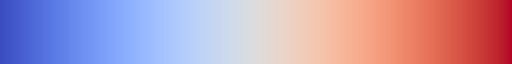

In [2]:
scw = []

with open('../../data/processed_data/common/smooth-cool-warm-table-float-1024.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for i, rows in enumerate(reader):
        if i > 0:
            r = [float(i) for i in rows]
            scw.append(tuple(r[1:]))
            scw.append(r[0])
            
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = list(seq) + [(None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return colors.LinearSegmentedColormap('CustomMap', cdict)

c = colors.ColorConverter().to_rgb
rvb = make_colormap(scw)
rvb

# Color palette

In [3]:
blue = [0.229999504, 0.298998934, 0.754000139]
red = [0.706000136, 0.015991824, 0.150000072]
purple = [0.4588, 0.4392, 0.7020]
mint = [0.1059, 0.6196, 0.4667]

# Load trained FINDR model variables

In [4]:
data = np.load(
    '../../data/processed_data/extended_data_figure_5/ddmlineattractor_cFINDR.npz'
)
x_=data['x_']
y_=data['y_']
u_=data['u_']
v_=data['v_']
z_pc_=data['z_pc_']
gammas = np.load("../../data/processed_data/common/gammas.npy")

# Generate vector field and trajectories

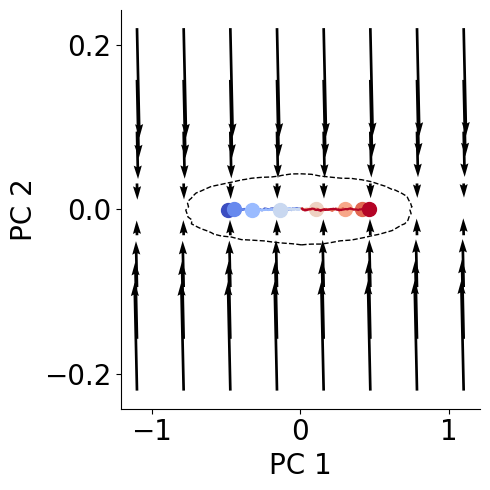

In [5]:
cmap = rvb
cmap1 = colors.ListedColormap(['white', 'None', 'white'])
cmap2 = colors.ListedColormap(['white'])
norm = colors.Normalize(vmin=-3.5, vmax=3.5)
flip_horizontally=-1
flip_vertically=1
time=100

evidences = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5] # in gamma

xrange = (
    np.abs(np.quantile(z_pc_[:,:,0].flatten(), 0.01)) + \
    np.abs(np.quantile(z_pc_[:,:,0].flatten(), 0.99))
)/2 # scale the axes so that the latent trajectories lie between -1 and 1 in PC 1 direction

# compute the evidence-conditioned average trajectories
avg_trajectories = [np.mean(z_pc_[(gammas == evidences[i]),:,:], axis=0) for i in range(len(evidences))]

z_pc__ = np.reshape(z_pc_[:,:time, :], (-1, 2))
thresh = 50
counts,xbins,ybins = np.histogram2d(
    flip_horizontally * z_pc__[:,0] / xrange, 
    flip_vertically * z_pc__[:,1] / xrange,
    bins=30
)

fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(
    flip_horizontally * x_/xrange, 
    flip_vertically * y_/xrange, 
    flip_horizontally * u_/xrange, 
    flip_vertically * v_/xrange, 
    angles='xy', color='black', scale_units='xy', scale=50, zorder=1000
)

for i in range(len(evidences)):
    ax.plot(
        flip_horizontally * avg_trajectories[i][:time, 0]/xrange, 
        flip_vertically * avg_trajectories[i][:time, 1]/xrange, 
        '-', color=cmap(norm(evidences[i])), zorder=1100
    )
    ax.plot(
        [flip_horizontally * avg_trajectories[i][time, 0]/xrange], 
        [flip_vertically * avg_trajectories[i][time, 1]/xrange], 
        'o', markersize=10, color=cmap(norm(evidences[i])), zorder=1100
    ) # final state at time=1s

xx = x_/xrange
yy = y_/xrange
zz = (xbins[0] < xx) * (xx < xbins[-1]) * (ybins[0] < yy) * (yy < ybins[-1])
cs = ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
linewidths=1, linestyles = "dashed", cmap = 'gray', levels = [thresh,100000], zorder=1001)

ax.set_ylabel("PC 2", fontsize=20)
ax.set_xlabel("PC 1", fontsize=20)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-.2, 0, 0.2])
ax.tick_params(axis='both', which='major', labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()